In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import pandas as pd
import numpy as np
import sklearn
import re
import math
import joblib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report
)

from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup
)

import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

from transformers import BertTokenizer, BertForMaskedLM

from sklearn.metrics import (
    recall_score,
    precision_score
  )

from sklearn.metrics import multilabel_confusion_matrix

In [3]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk

In [4]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [5]:
time_now = pd.Timestamp.now().strftime("%m-%d-%H-%M")
print(f"Time now: {time_now}")

Time now: 06-03-01-26


# Config

In [6]:
class Config:
    def __init__(self):
        super(Config, self).__init__()

        self.SEED = 42
        self.MODEL_PATH = 'allenai/scibert_scivocab_uncased'
        self.NUM_LABELS_TA = 14
        self.NUM_LABELS_TE = 185

        self.TOKENIZER = AutoTokenizer.from_pretrained(self.MODEL_PATH)
        self.MAX_LENGTH = 320
        self.BATCH_SIZE = 16

        self.DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.FULL_FINETUNING = True
        self.LR = 3e-5
        self.OPTIMIZER = 'AdamW'
        self.CRITERION = 'BCEWithLogitsLoss'
        self.N_VALIDATE_DUR_TRAIN = 3
        self.N_WARMUP = 0
        self.SAVE_BEST_ONLY = True
        self.EPOCHS = 50

In [7]:
TACTIC = ['TA0001', 'TA0002', 'TA0003', 'TA0004', 'TA0005', 'TA0006', 'TA0007', 'TA0008', 'TA0009', 'TA0010', 'TA0011', 'TA0040', 'TA0042', 'TA0043']
TECHNIQUE = ['T1001', 'T1003', 'T1005', 'T1006', 'T1007', 'T1008', 'T1010', 'T1011', 'T1012', 'T1014', 'T1016', 'T1018', 'T1020', 'T1021', 'T1025', 'T1027', 'T1029', 'T1030', 'T1033', 'T1036', 'T1037', 'T1039', 'T1040', 'T1041', 'T1046', 'T1047', 'T1048', 'T1049', 'T1052', 'T1053', 'T1055', 'T1056', 'T1057', 'T1059', 'T1068', 'T1069', 'T1071', 'T1072', 'T1074', 'T1078', 'T1080', 'T1082', 'T1083', 'T1087', 'T1090', 'T1091', 'T1092', 'T1095', 'T1098', 'T1102', 'T1104', 'T1105', 'T1106', 'T1110', 'T1111', 'T1112', 'T1113', 'T1114', 'T1115', 'T1119', 'T1120', 'T1123', 'T1124', 'T1125', 'T1127', 'T1129', 'T1132', 'T1133', 'T1134', 'T1135', 'T1136', 'T1137', 'T1140', 'T1176', 'T1185', 'T1187', 'T1189', 'T1190', 'T1195', 'T1197', 'T1199', 'T1200', 'T1201', 'T1202', 'T1203', 'T1204', 'T1205', 'T1207', 'T1210', 'T1211', 'T1212', 'T1213', 'T1216', 'T1218', 'T1220', 'T1221', 'T1222', 'T1480', 'T1482', 'T1485', 'T1486', 'T1489', 'T1490', 'T1491', 'T1495', 'T1496', 'T1497', 'T1498', 'T1499', 'T1505', 'T1518', 'T1525', 'T1526', 'T1528', 'T1529', 'T1531', 'T1534', 'T1535', 'T1537', 'T1538', 'T1539', 'T1542', 'T1543', 'T1546', 'T1547', 'T1548', 'T1550', 'T1552', 'T1553', 'T1555', 'T1556', 'T1557', 'T1558', 'T1559', 'T1560', 'T1561', 'T1562', 'T1563', 'T1564', 'T1565', 'T1566', 'T1567', 'T1568', 'T1569', 'T1570', 'T1571', 'T1572', 'T1573', 'T1574', 'T1578', 'T1580', 'T1583', 'T1584', 'T1585', 'T1586', 'T1587', 'T1588', 'T1589', 'T1590', 'T1591', 'T1592', 'T1593', 'T1594', 'T1595', 'T1596', 'T1597', 'T1598', 'T1599', 'T1600', 'T1601', 'T1602', 'T1606', 'T1608', 'T1609', 'T1610', 'T1611', 'T1612', 'T1613', 'T1614', 'T1615', 'T1619', 'T1620', 'T1621', 'T1622', 'T1647']
TACTICS_TECHNIQUES_RELATIONSHIP_DF = {
"TA0001":pd.Series(['T1078', 'T1091', 'T1133', 'T1189', 'T1190', 'T1195', 'T1199', 'T1200', 'T1566', 'T1659', 'T1669']),
"TA0002":pd.Series(['T1047', 'T1053', 'T1059', 'T1072', 'T1106', 'T1129', 'T1203', 'T1204', 'T1559', 'T1569', 'T1609', 'T1610', 'T1648', 'T1651', 'T1674', 'T1675']),
"TA0003":pd.Series(['T1037', 'T1053', 'T1078', 'T1098', 'T1112', 'T1133', 'T1136', 'T1137', 'T1176', 'T1197', 'T1205', 'T1505', 'T1525', 'T1542', 'T1543', 'T1546', 'T1547', 'T1554', 'T1556', 'T1574', 'T1653', 'T1668', 'T1671']),
"TA0004":pd.Series(['T1037', 'T1053', 'T1055', 'T1068', 'T1078', 'T1098', 'T1134', 'T1484', 'T1543', 'T1546', 'T1547', 'T1548', 'T1574', 'T1611']),
"TA0005":pd.Series(['T1006', 'T1014', 'T1027', 'T1036', 'T1055', 'T1070', 'T1078', 'T1112', 'T1127', 'T1134', 'T1140', 'T1197', 'T1202', 'T1205', 'T1207', 'T1211', 'T1216', 'T1218', 'T1220', 'T1221', 'T1222', 'T1480', 'T1484', 'T1497', 'T1535', 'T1542', 'T1548', 'T1550', 'T1553', 'T1556', 'T1562', 'T1564', 'T1574', 'T1578', 'T1599', 'T1600', 'T1601', 'T1610', 'T1612', 'T1620', 'T1622', 'T1647', 'T1656', 'T1666', 'T1672']),
"TA0006":pd.Series(['T1003', 'T1040', 'T1056', 'T1110', 'T1111', 'T1187', 'T1212', 'T1528', 'T1539', 'T1552', 'T1555', 'T1556', 'T1557', 'T1558', 'T1606', 'T1621', 'T1649']),
"TA0007":pd.Series(['T1007', 'T1010', 'T1012', 'T1016', 'T1018', 'T1033', 'T1040', 'T1046', 'T1049', 'T1057', 'T1069', 'T1082', 'T1083', 'T1087', 'T1120', 'T1124', 'T1135', 'T1201', 'T1217', 'T1482', 'T1497', 'T1518', 'T1526', 'T1538', 'T1580', 'T1613', 'T1614', 'T1615', 'T1619', 'T1622', 'T1652', 'T1654', 'T1673']),
"TA0008":pd.Series(['T1021', 'T1072', 'T1080', 'T1091', 'T1210', 'T1534', 'T1550', 'T1563', 'T1570']),
"TA0009":pd.Series(['T1005', 'T1025', 'T1039', 'T1056', 'T1074', 'T1113', 'T1114', 'T1115', 'T1119', 'T1123', 'T1125', 'T1185', 'T1213', 'T1530', 'T1557', 'T1560', 'T1602']),
"TA0010":pd.Series(['T1011', 'T1020', 'T1029', 'T1030', 'T1041', 'T1048', 'T1052', 'T1537', 'T1567']),
"TA0011":pd.Series(['T1001', 'T1008', 'T1071', 'T1090', 'T1092', 'T1095', 'T1102', 'T1104', 'T1105', 'T1132', 'T1205', 'T1219', 'T1568', 'T1571', 'T1572', 'T1573', 'T1659', 'T1665']),
"TA0040":pd.Series(['T1485', 'T1486', 'T1489', 'T1490', 'T1491', 'T1495', 'T1496', 'T1498', 'T1499', 'T1529', 'T1531', 'T1561', 'T1565', 'T1657', 'T1667']),                
"TA0042":pd.Series(['T1583', 'T1584', 'T1585', 'T1586', 'T1587', 'T1588', 'T1608', 'T1650']),
"TA0043":pd.Series(['T1589', 'T1590', 'T1591', 'T1592', 'T1593', 'T1594', 'T1595', 'T1596', 'T1597', 'T1598'])
}

In [8]:
df = pd.read_csv('merged_all_columns.csv', encoding='utf-8')
# df_attack['tactic_label'] = df_attack.apply(lambda x: list(x[TACTIC]), axis=1)
# df_attack['technique_label'] = df_attack.apply(lambda x: list(x[TECHNIQUE]), axis=1)

df_tactic_labels = df[TACTIC]
df_technique_labels = df[TECHNIQUE]

In [9]:
print(df_tactic_labels)

      TA0001  TA0002  TA0003  TA0004  TA0005  TA0006  TA0007  TA0008  TA0009  \
0          1       1       0       0       0       0       0       0       0   
1          1       1       0       0       0       0       0       0       0   
2          0       1       0       0       0       1       0       0       0   
3          1       1       0       0       0       0       0       0       0   
4          1       0       0       1       1       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
1513       0       1       1       0       0       0       0       0       0   
1514       0       0       0       0       0       0       0       0       0   
1515       0       0       0       1       0       0       0       0       0   
1516       0       1       0       0       0       0       0       0       1   
1517       0       0       0       0       0       0       0       0       0   

      TA0010  TA0011  TA0040  TA0042  T

In [10]:
print(df_technique_labels)

      T1001  T1003  T1005  T1006  T1007  T1008  T1010  T1011  T1012  T1014  \
0         0      0      0      0      0      0      0      0      0      0   
1         0      0      0      0      0      0      0      0      0      0   
2         0      1      0      0      0      0      0      0      0      0   
3         0      0      0      0      0      0      0      0      0      0   
4         0      0      0      0      0      0      0      0      0      0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
1513      0      0      0      0      0      0      0      0      0      0   
1514      0      0      0      0      0      0      0      0      0      0   
1515      0      0      0      0      0      0      0      0      0      0   
1516      0      0      1      0      0      0      0      0      0      0   
1517      0      0      0      0      0      0      0      0      0      0   

      ...  T1611  T1612  T1613  T1614  T1615  T1619  T1620  T16

In [11]:
df['tactic_label'] = df.apply(lambda x: list(x[TACTIC]), axis=1)
df['technique_label'] = df.apply(lambda x: list(x[TECHNIQUE]), axis=1)


# Data processing

In [12]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk

In [13]:
import nltk

resources = [
    "punkt",
    "stopwords",
    "wordnet",
    "omw-1.4",
    "averaged_perceptron_tagger",
    "averaged_perceptron_tagger_eng"
]

for res in resources:
    try:
        nltk.data.find(res)
        print(f"{res} ✅ 已安裝")
    except LookupError:
        print(f"{res} ⛔ 未安裝，開始下載...")
        nltk.download(res)


punkt ⛔ 未安裝，開始下載...
stopwords ⛔ 未安裝，開始下載...
wordnet ⛔ 未安裝，開始下載...
omw-1.4 ⛔ 未安裝，開始下載...
averaged_perceptron_tagger ⛔ 未安裝，開始下載...
averaged_perceptron_tagger_eng ⛔ 未安裝，開始下載...


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_t

In [14]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

def ioc_sub(text):
    def reg_handler(obj):
        s = obj.group(1)
        s = ' '.join(s.split('\\'))
        return s

    def file_handler(obj):
        s = obj.group(2)
        s = s.split('\\')[-1]
        return s
    
    text = re.sub(r'(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|\[\.\])){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\/([0-2][0-9]|3[0-2]|[0-9]))?', 'IPv4', text)
    text = re.sub(r'\b(\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3})\b', 'IP', text)
    text = re.sub(r'\b(CVE\-[0-9]{4}\-[0-9]{4,6})\b', 'CVE', text)
    text = re.sub(r'CVE-[0-9]{4}-[0-9]{4,6}', 'vulnerability', text)
    text = re.sub(r'\b([a-z][_a-z0-9-.]+@[a-z0-9-]+\.[a-z]+)\b', 'email', text)
    text = re.sub(r'\b((HKLM|HKCU|HKCR|HKU|HKCC)\\[\\A-Za-z0-9-_]+)\b', reg_handler, text)
    text = re.sub(r'\b([a-zA-Z]{1}:\\([0-9a-zA-Z_\.\-\/\\]+))\b', file_handler, text)
    text = re.sub(r'\b([a-f0-9]{32}|[A-F0-9]{32})\b', 'MD5', text)
    text = re.sub(r'\b([a-f0-9]{40}|[A-F0-9]{40})\b', 'SHA1', text)
    text = re.sub(r'\b([a-f0-9]{64}|[A-F0-9]{64})\b', 'SHA256', text)
    text = re.sub(r'\d+:[A-Za-z0-9/+]+:[A-Za-z0-9/+]+', 'ssdeep', text)
    text = re.sub(r'\b[a-fA-F\d]{32}\b|\b[a-fA-F\d]{40}\b|\b[a-fA-F\d]{64}\b', 'hash', text)
    text = re.sub(r'h[tx][tx]ps?:[\\\/][\\\/](?:[0-9a-zA-Z_\.\-\/\\]|\[\.\])+', 'URL', text)
    text = re.sub(r'((?:[0-9a-zA-Z_\-]+\.)+(?:(?!exe|dll)[a-z]{2,4}))', 'domain', text)
    text = re.sub(r'[a-fA-F0-9]{16}', '', text)
    text = re.sub(r'[0-9]{8}', '', text)
    text = re.sub(r'x[A-Fa-f0-9]{2}', '', text)
    
    return text

def rmstopword_and_lemmatize(text):
    token = [word for word in word_tokenize(text.lower()) if word not in stopwords.words('english')]
    # tag = pos_tag(token)
    tag = nltk.pos_tag(token, lang='eng')
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(list(map(lambda x: lemmatizer.lemmatize(x[0], pos=get_wordnet_pos(x[1])), tag)))
    
    return text

def preprocess(text):
    text = str(text)
    #text = text.lower()
    text = re.sub(r'etc\.', '', text)
    text = re.sub(r'et al\.', '', text)
    text = re.sub(r'e\.g\.', '', text)
    text = re.sub(r'i\.e\.', '', text)
    #text = re.sub(r'\[.\]', '.', text)
    text = re.sub(r'\[\d+\]', '', text)
    
    text = ioc_sub(text)
    
    text = re.sub(r'[^A-Za-z0-9_\[\]]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    text = rmstopword_and_lemmatize(text)
    
    text = re.sub(r'[\[\]]', ' ', text)
    text = re.sub(r' [a-z0-9] ', '', text)
    
    return text


In [15]:
df['text_clean'] = df['Text'].map(lambda t: preprocess(t))

In [16]:
print(df['text_clean'][0])

waspthemes visual cs style editor aka yellow pencil visual theme customizer plugin2wordpress allows yp_option_update csrf demonstrate use yp_remote_get obtain admin access


In [17]:
print(df.iloc[0])

ID                                                    CVE_2019_11886
Text               The WaspThemes Visual CSS Style Editor (aka ye...
TA0001                                                             1
TA0002                                                             1
TA0003                                                             0
                                         ...                        
T1622                                                              0
T1647                                                              0
tactic_label              [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
technique_label    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
text_clean         waspthemes visual cs style editor aka yellow p...
Name: 0, Length: 204, dtype: object


# Dataset & Dataloader

In [18]:
def get_texts(df):
    texts = df['text']
    texts = texts.values.tolist()
    return texts

def get_labels(df):
    labels = df['labels'].values
    return labels

def get_ids(df):
    ids = df['ID'].values.tolist()

In [19]:
from torch.utils.data import Dataset, DataLoader
class TransformerDataset_ta(Dataset):
    def __init__(self, df, indices, set_type=None):
        super(TransformerDataset_ta, self).__init__()

        df = df.iloc[indices]
        self.texts = get_texts(df)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(df)

        self.tokenizer = Config().TOKENIZER
        self.max_length = Config().MAX_LENGTH

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        tokenized = self.tokenizer.encode_plus(
            self.texts[index],
            max_length=self.max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )

        input_ids = tokenized['input_ids'].squeeze()
        attention_mask = tokenized['attention_mask'].squeeze()

        if self.set_type != 'test':
            return {
                'input_ids': input_ids.long(),
                'attention_mask': attention_mask.long(),
                'labels': torch.Tensor(self.labels[index]).float(),
            }

        return {
            'input_ids': input_ids.long(),
            'attention_mask': attention_mask.long(),
        }

In [20]:

class TransformerDataset_te(Dataset):
    def __init__(self, df, indices, set_type=None):
        super(TransformerDataset_te, self).__init__()

        df = df.iloc[indices]
        self.texts = get_texts(df)
        self.set_type = set_type
        if self.set_type != 'test':
            self.labels = get_labels(df)

        self.tokenizer = Config().TOKENIZER
        self.max_length = Config().MAX_LENGTH

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        tokenized = self.tokenizer.encode_plus(
            self.texts[index],
            max_length=self.max_length,
            pad_to_max_length=True,
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )

        input_ids = tokenized['input_ids'].squeeze()
        attention_mask = tokenized['attention_mask'].squeeze()

        if self.set_type != 'test':
            return {
                'input_ids': input_ids.long(),
                'attention_mask': attention_mask.long(),
                'labels': torch.Tensor(self.labels[index]).float(),
            }

        return {
            'input_ids': input_ids.long(),
            'attention_mask': attention_mask.long(),
        }

In [21]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=2222)
validation, test = train_test_split(test, test_size=0.5, random_state=2222)

In [22]:
# df_ta_train = train[['text_clean', 'tactic_label']]
# df_ta_val = validation[['text_clean', 'tactic_label']]
# df_ta_test = test[['text_clean', 'tactic_label']]
# df_ta_train = df_ta_train.rename(columns={'text_clean':'text', 'tactic_label':'labels'})
# df_ta_val = df_ta_val.rename(columns={'text_clean':'text', 'tactic_label':'labels'})
# df_ta_test = df_ta_test.rename(columns={'text_clean':'text', 'tactic_label':'labels'})


In [23]:
df_te_train = df.iloc[train.index][['text_clean', 'technique_label']]
df_te_val = df.iloc[validation.index][['text_clean', 'technique_label']]
df_te_test = df.iloc[test.index][['text_clean', 'technique_label']]
df_te_train = df_te_train.rename(columns={'text_clean':'text', 'technique_label':'labels'})
df_te_val = df_te_val.rename(columns={'text_clean':'text', 'technique_label':'labels'})
df_te_test = df_te_test.rename(columns={'text_clean':'text', 'technique_label':'labels'})

In [24]:
# train_data_ta = TransformerDataset_ta(df_ta_train, range(len(df_ta_train)))
# val_data_ta = TransformerDataset_ta(df_ta_val, range(len(df_ta_val)))
# test_data_ta = TransformerDataset_ta(df_ta_test, range(len(df_ta_test)))

In [25]:
train_data_te = TransformerDataset_te(df_te_train, range(len(df_te_train)))
val_data_te = TransformerDataset_te(df_te_val, range(len(df_te_val)))
test_data_te = TransformerDataset_te(df_te_test, range(len(df_te_test)))

In [26]:
# train_dataloader_ta = DataLoader(train_data_ta, batch_size=Config().BATCH_SIZE)
# val_dataloader_ta = DataLoader(val_data_ta, batch_size=Config().BATCH_SIZE)
# test_dataloader_ta = DataLoader(test_data_ta, batch_size=Config().BATCH_SIZE)

In [27]:
train_dataloader_te = DataLoader(train_data_te, batch_size=Config().BATCH_SIZE)
val_dataloader_te = DataLoader(val_data_te, batch_size=Config().BATCH_SIZE)
test_dataloader_te = DataLoader(test_data_te, batch_size=Config().BATCH_SIZE)

In [28]:
train_dataloader = train_dataloader_te
val_dataloader = val_dataloader_te
test_dataloader = test_dataloader_te

In [29]:
b = next(iter(train_dataloader_te))
for k, v in b.items():
    print(f'{k} shape: {v.shape}')

input_ids shape: torch.Size([16, 320])
attention_mask shape: torch.Size([16, 320])
labels shape: torch.Size([16, 185])


# Model

In [30]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.transformer_model = AutoModel.from_pretrained(
                Config().MODEL_PATH
        )
        self.dropout = nn.Dropout(0.3)

        self.output = nn.Linear(768, Config().NUM_LABELS_TE)

    def forward(
        self,
        input_ids,
        attention_mask=None,
        token_type_ids=None
        ):

        _, o2 = self.transformer_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=False
        )

        x = self.dropout(o2)
        out = self.output(x)

        return out

# Train and test

In [31]:
BEST_F1 = 0
BEST_TRUE = []
BEST_PREDICTED = []

In [32]:
metrics_log = [] 

In [33]:
def val(model, val_dataloader, criterion, is_final_test=False):
    global BEST_F1, BEST_TRUE, BEST_PREDICTED, device

    val_loss = 0
    true, pred = [], []

    model.eval()

    results = {}

    for step, batch in enumerate(val_dataloader):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)

            loss = criterion(logits, b_labels)
            val_loss += loss.item()

            logits = torch.sigmoid(logits)
            logits = np.round(logits.cpu().numpy())
            labels = b_labels.cpu().numpy()

            pred.extend(logits)
            true.extend(labels)

    # avg_val_loss = val_loss / len(val_dataloader)
    # print('Val loss:', avg_val_loss)
    # print('Val accuracy:', accuracy_score(true, pred))

    # print('Val precision:', precision_score(true, pred, average='weighted'))
    # print('Val recall:', recall_score(true, pred, average='weighted'))

    # val_micro_f1_score = f1_score(true, pred, average='micro')
    # print('Val micro f1 score:', val_micro_f1_score)

    # val_macro_f1_score = f1_score(true, pred, average='macro')
    # print('Val macro f1 score:', val_macro_f1_score)

    val_weighted_f1_score = f1_score(true, pred, average='weighted')
    # print('Val weighted f1 score:', val_weighted_f1_score)

    results.update({
        "f1_sampled": f1_score(true, pred, average='samples', zero_division=0),
        "f1_micro": f1_score(true, pred, average='micro', zero_division=0),
        "f1_macro": f1_score(true, pred, average='macro', zero_division=0),
        "f_05_sample": fbeta_score(true, pred, average='samples', beta=0.5, zero_division=0),
        "f_05_micro": fbeta_score(true, pred, average='micro', beta=0.5, zero_division=0),
        "f_05_macro": fbeta_score(true, pred, average='macro', beta=0.5, zero_division=0),
        "precision_sampled": precision_score(true, pred, average='samples', zero_division=0),
        "precision_micro": precision_score(true, pred, average='micro', zero_division=0),
        "precision_macro": precision_score(true, pred, average='macro', zero_division=0),
        "recall_sampled": recall_score(true, pred, average='samples', zero_division=0),
        "recall_micro": recall_score(true, pred, average='micro', zero_division=0),
        "recall_macro": recall_score(true, pred, average='macro', zero_division=0),
        "accuracy": accuracy_score(true, pred),
        })

    labels_float = labels.astype(float)
    results.update({
        "coverage_error": coverage_error(labels_float, logits),
        "label_ranking_loss": label_ranking_loss(labels_float, logits),
        "lrap": label_ranking_average_precision_score(labels_float, logits),
    })

    metrics_log.append(results.copy())

    print(results)


    if (is_final_test is True):
      BEST_F1 = val_weighted_f1_score
      BEST_TRUE = true
      BEST_PREDICTED = pred
    elif (val_weighted_f1_score > BEST_F1):
      BEST_F1 = val_weighted_f1_score
      BEST_TRUE = true
      BEST_PREDICTED = pred

    return val_weighted_f1_score



In [34]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch):
    global device
    nv = Config().N_VALIDATE_DUR_TRAIN
    temp = len(train_dataloader) // nv
    temp = temp - (temp % 100)
    validate_at_steps = [temp * x for x in range(1, nv + 1)]

    train_loss = 0
    train_losses = []

    for step, batch in enumerate(tqdm(train_dataloader,
                                      desc='Epoch ' + str(epoch))):
        model.train()

        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        optimizer.zero_grad()

        logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)

        loss = criterion(logits, b_labels)
        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        scheduler.step()

        if step in validate_at_steps:
            print(f'-- Step: {step}')
            _ = val(model, val_dataloader, criterion)


    avg_train_loss = train_loss / len(train_dataloader)
    print('Training loss:', avg_train_loss)

In [35]:
def run():
    global train_data, val_data, test_data, train_dataloader, val_dataloader, test_dataloader, model
    torch.manual_seed(Config().SEED)

    criterion = nn.BCEWithLogitsLoss()

    if Config().FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {
                "params": [
                    p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.001,
            },
            {
                "params": [
                    p for n, p in param_optimizer if any(nd in n for nd in no_decay)
                ],
                "weight_decay": 0.0,
            },
        ]
        optimizer = optim.AdamW(optimizer_parameters, lr=Config().LR)

    num_training_steps = len(train_dataloader) * Config().EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    max_val_weighted_f1_score = float('-inf')
    for epoch in range(Config().EPOCHS):
        train(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epoch)
        val_weighted_f1_score = val(model, val_dataloader, criterion)

        if Config().SAVE_BEST_ONLY:
            if val_weighted_f1_score > max_val_weighted_f1_score:
                best_model = copy.deepcopy(model)

                model_name = 'scibert_best_model'
                torch.save(best_model.state_dict(), model_name + '.pt')

                print(f'--- Best Model. Val: {max_val_weighted_f1_score} -> {val_weighted_f1_score}')
                max_val_weighted_f1_score = val_weighted_f1_score

    return best_model, max_val_weighted_f1_score

# Tactic_multi model

In [36]:
from sklearn.metrics import coverage_error, label_ranking_average_precision_score, label_ranking_loss
from sklearn.metrics import hamming_loss, precision_score, recall_score, f1_score, fbeta_score
from sklearn.metrics import accuracy_score

In [37]:
project_dir = './'
config = Config()
device = Config().DEVICE
model = Model()
model.to(device)

Model(
  (transformer_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [38]:
best_model_ta, best_val_weighted_f1_score_ta = run()

Epoch 0:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 0:   4%|▍         | 3/76 [00:01<00:21,  3.43it/s]

{'f1_sampled': 0.018435721784429676, 'f1_micro': 0.01873577306951497, 'f1_macro': 0.011367097965311256, 'f_05_sample': 0.011757944995078514, 'f_05_micro': 0.011892588805406126, 'f_05_macro': 0.008397597468596018, 'precision_sampled': 0.009471350922537558, 'precision_micro': 0.00956381837683232, 'precision_macro': 0.007222738206039364, 'recall_sampled': 0.4337719298245614, 'recall_micro': 0.45726495726495725, 'recall_macro': 0.08948463169051404, 'accuracy': 0.0, 'coverage_error': np.float64(128.25), 'label_ranking_loss': np.float64(0.5356569052338748), 'lrap': np.float64(0.019935716529289774)}


Epoch 0: 100%|██████████| 76/76 [00:08<00:00,  9.49it/s]


Training loss: 0.35152831752049296
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}
--- Best Model. Val: -inf -> 0.0


Epoch 1:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 1:   4%|▍         | 3/76 [00:00<00:17,  4.19it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 1: 100%|██████████| 76/76 [00:07<00:00,  9.67it/s]


Training loss: 0.1136136903966728
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 2:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 2:   4%|▍         | 3/76 [00:00<00:15,  4.60it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 2: 100%|██████████| 76/76 [00:07<00:00,  9.80it/s]


Training loss: 0.06685077349998449
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 3:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 3:   4%|▍         | 3/76 [00:00<00:16,  4.33it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 3: 100%|██████████| 76/76 [00:07<00:00,  9.70it/s]


Training loss: 0.05225593214364428
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 4:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 4:   4%|▍         | 3/76 [00:00<00:13,  5.53it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 4: 100%|██████████| 76/76 [00:07<00:00,  9.94it/s]


Training loss: 0.045560182268290145
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 5:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 5:   4%|▍         | 3/76 [00:00<00:17,  4.28it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 5: 100%|██████████| 76/76 [00:07<00:00,  9.59it/s]


Training loss: 0.041954364921701584
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 6:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 6:   1%|▏         | 1/76 [00:00<00:53,  1.40it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 6: 100%|██████████| 76/76 [00:07<00:00,  9.60it/s]


Training loss: 0.03962287377860201
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 7:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 7:   4%|▍         | 3/76 [00:00<00:19,  3.83it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 7: 100%|██████████| 76/76 [00:07<00:00,  9.52it/s]


Training loss: 0.038321074392450485
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 8:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 8:   1%|▏         | 1/76 [00:00<00:49,  1.52it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 8: 100%|██████████| 76/76 [00:07<00:00,  9.68it/s]


Training loss: 0.0370958477846886
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 9:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 9:   4%|▍         | 3/76 [00:00<00:17,  4.22it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 9: 100%|██████████| 76/76 [00:07<00:00,  9.65it/s]


Training loss: 0.03639127326344973
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 10:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 10:   4%|▍         | 3/76 [00:00<00:16,  4.31it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 10: 100%|██████████| 76/76 [00:07<00:00,  9.68it/s]


Training loss: 0.03592125630300296
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 11:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 11:   4%|▍         | 3/76 [00:00<00:17,  4.17it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 11: 100%|██████████| 76/76 [00:07<00:00,  9.61it/s]


Training loss: 0.03540057421808964
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 12:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 12:   1%|▏         | 1/76 [00:00<00:50,  1.47it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 12: 100%|██████████| 76/76 [00:07<00:00,  9.65it/s]


Training loss: 0.0349881434568057
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 13:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 13:   4%|▍         | 3/76 [00:00<00:18,  3.89it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 13: 100%|██████████| 76/76 [00:07<00:00,  9.51it/s]


Training loss: 0.03482876816078236
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 14:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 14:   4%|▍         | 3/76 [00:00<00:16,  4.37it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 14: 100%|██████████| 76/76 [00:07<00:00,  9.63it/s]


Training loss: 0.03448297580900161
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 15:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 15:   4%|▍         | 3/76 [00:00<00:16,  4.47it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 15: 100%|██████████| 76/76 [00:07<00:00,  9.68it/s]


Training loss: 0.034419220063443244
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 16:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 16:   4%|▍         | 3/76 [00:00<00:16,  4.54it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 16: 100%|██████████| 76/76 [00:07<00:00,  9.70it/s]


Training loss: 0.034199432249328025
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 17:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 17:   4%|▍         | 3/76 [00:00<00:17,  4.14it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 17: 100%|██████████| 76/76 [00:07<00:00,  9.63it/s]


Training loss: 0.033979008390911315
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 18:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 18:   4%|▍         | 3/76 [00:00<00:13,  5.22it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 18: 100%|██████████| 76/76 [00:07<00:00,  9.86it/s]


Training loss: 0.034030952735951074
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 19:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 19:   4%|▍         | 3/76 [00:00<00:14,  4.89it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 19: 100%|██████████| 76/76 [00:07<00:00,  9.74it/s]


Training loss: 0.033742529977309074
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 20:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 20:   4%|▍         | 3/76 [00:00<00:18,  3.97it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 20: 100%|██████████| 76/76 [00:07<00:00,  9.51it/s]


Training loss: 0.03375868310563659
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 21:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 21:   4%|▍         | 3/76 [00:00<00:16,  4.48it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 21: 100%|██████████| 76/76 [00:07<00:00,  9.69it/s]


Training loss: 0.03370264160299772
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 22:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 22:   4%|▍         | 3/76 [00:00<00:17,  4.15it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 22: 100%|██████████| 76/76 [00:07<00:00,  9.62it/s]


Training loss: 0.03368409345612714
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 23:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 23:   4%|▍         | 3/76 [00:00<00:17,  4.12it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 23: 100%|██████████| 76/76 [00:07<00:00,  9.58it/s]


Training loss: 0.03363708955676932
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 24:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 24:   4%|▍         | 3/76 [00:00<00:17,  4.14it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 24: 100%|██████████| 76/76 [00:07<00:00,  9.64it/s]


Training loss: 0.033565314143503965
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 25:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 25:   4%|▍         | 3/76 [00:00<00:18,  3.95it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 25: 100%|██████████| 76/76 [00:07<00:00,  9.60it/s]


Training loss: 0.03352190431599554
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 26:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 26:   1%|▏         | 1/76 [00:00<00:45,  1.65it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 26: 100%|██████████| 76/76 [00:07<00:00,  9.75it/s]


Training loss: 0.033431350915251595
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 27:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 27:   4%|▍         | 3/76 [00:00<00:16,  4.34it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 27: 100%|██████████| 76/76 [00:07<00:00,  9.69it/s]


Training loss: 0.033240286682389285
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 28:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 28:   4%|▍         | 3/76 [00:00<00:18,  3.93it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 28: 100%|██████████| 76/76 [00:07<00:00,  9.58it/s]


Training loss: 0.03288599473767375
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 29:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 29:   4%|▍         | 3/76 [00:00<00:14,  5.01it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 29: 100%|██████████| 76/76 [00:07<00:00,  9.79it/s]


Training loss: 0.03257161038192479
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 30:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 30:   4%|▍         | 3/76 [00:00<00:17,  4.19it/s]

{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 30: 100%|██████████| 76/76 [00:07<00:00,  9.59it/s]


Training loss: 0.03187476201473098
{'f1_sampled': 0.0, 'f1_micro': 0.0, 'f1_macro': 0.0, 'f_05_sample': 0.0, 'f_05_micro': 0.0, 'f_05_macro': 0.0, 'precision_sampled': 0.0, 'precision_micro': 0.0, 'precision_macro': 0.0, 'recall_sampled': 0.0, 'recall_micro': 0.0, 'recall_macro': 0.0, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 31:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 31:   4%|▍         | 3/76 [00:00<00:17,  4.27it/s]

{'f1_sampled': 0.0043859649122807015, 'f1_micro': 0.008438818565400843, 'f1_macro': 0.0005689900426742531, 'f_05_sample': 0.005482456140350878, 'f_05_micro': 0.02032520325203252, 'f_05_macro': 0.0009652509652509653, 'precision_sampled': 0.006578947368421052, 'precision_micro': 0.3333333333333333, 'precision_macro': 0.0018018018018018016, 'recall_sampled': 0.003289473684210526, 'recall_micro': 0.004273504273504274, 'recall_macro': 0.00033783783783783786, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 31: 100%|██████████| 76/76 [00:07<00:00,  9.65it/s]


Training loss: 0.031660085789075025
{'f1_sampled': 0.015350877192982454, 'f1_micro': 0.02510460251046025, 'f1_macro': 0.0015444015444015444, 'f_05_sample': 0.01754385964912281, 'f_05_micro': 0.05905511811023622, 'f_05_macro': 0.0022522522522522522, 'precision_sampled': 0.019736842105263157, 'precision_micro': 0.6, 'precision_macro': 0.003243243243243243, 'recall_sampled': 0.013157894736842105, 'recall_micro': 0.01282051282051282, 'recall_macro': 0.0010135135135135136, 'accuracy': 0.06578947368421052, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}
--- Best Model. Val: 0.0 -> 0.019536019536019536


Epoch 32:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 32:   4%|▍         | 3/76 [00:00<00:15,  4.70it/s]

{'f1_sampled': 0.021929824561403508, 'f1_micro': 0.03333333333333333, 'f1_macro': 0.0019656019656019656, 'f_05_sample': 0.024122807017543862, 'f_05_micro': 0.07751937984496124, 'f_05_macro': 0.002702702702702703, 'precision_sampled': 0.02631578947368421, 'precision_micro': 0.6666666666666666, 'precision_macro': 0.0036036036036036032, 'recall_sampled': 0.019736842105263157, 'recall_micro': 0.017094017094017096, 'recall_macro': 0.0013513513513513514, 'accuracy': 0.07236842105263158, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 32: 100%|██████████| 76/76 [00:07<00:00,  9.73it/s]


Training loss: 0.031243205462631426
{'f1_sampled': 0.03289473684210526, 'f1_micro': 0.05622489959839357, 'f1_macro': 0.0024411508282476025, 'f_05_sample': 0.039473684210526314, 'f_05_micro': 0.11904761904761904, 'f_05_macro': 0.0024893314366998577, 'precision_sampled': 0.046052631578947366, 'precision_micro': 0.4666666666666667, 'precision_macro': 0.0025225225225225228, 'recall_sampled': 0.02631578947368421, 'recall_micro': 0.029914529914529916, 'recall_macro': 0.002364864864864865, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}
--- Best Model. Val: 0.019536019536019536 -> 0.030879514750482492


Epoch 33:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 33:   4%|▍         | 3/76 [00:00<00:17,  4.13it/s]

{'f1_sampled': 0.03289473684210526, 'f1_micro': 0.05622489959839357, 'f1_macro': 0.0024411508282476025, 'f_05_sample': 0.039473684210526314, 'f_05_micro': 0.11904761904761904, 'f_05_macro': 0.0024893314366998577, 'precision_sampled': 0.046052631578947366, 'precision_micro': 0.4666666666666667, 'precision_macro': 0.0025225225225225228, 'recall_sampled': 0.02631578947368421, 'recall_micro': 0.029914529914529916, 'recall_macro': 0.002364864864864865, 'accuracy': 0.05921052631578947, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 33: 100%|██████████| 76/76 [00:07<00:00,  9.55it/s]


Training loss: 0.030898223582066987
{'f1_sampled': 0.035087719298245605, 'f1_micro': 0.056, 'f1_macro': 0.002364864864864865, 'f_05_sample': 0.0405701754385965, 'f_05_micro': 0.1174496644295302, 'f_05_macro': 0.002364864864864865, 'precision_sampled': 0.046052631578947366, 'precision_micro': 0.4375, 'precision_macro': 0.002364864864864865, 'recall_sampled': 0.029605263157894735, 'recall_micro': 0.029914529914529916, 'recall_macro': 0.002364864864864865, 'accuracy': 0.06578947368421052, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 34:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 34:   4%|▍         | 3/76 [00:00<00:17,  4.16it/s]

{'f1_sampled': 0.035087719298245605, 'f1_micro': 0.055776892430278883, 'f1_macro': 0.0022932022932022934, 'f_05_sample': 0.0405701754385965, 'f_05_micro': 0.11589403973509933, 'f_05_macro': 0.0022522522522522522, 'precision_sampled': 0.046052631578947366, 'precision_micro': 0.4117647058823529, 'precision_macro': 0.0022257551669316376, 'recall_sampled': 0.029605263157894735, 'recall_micro': 0.029914529914529916, 'recall_macro': 0.002364864864864865, 'accuracy': 0.06578947368421052, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 34: 100%|██████████| 76/76 [00:07<00:00,  9.62it/s]


Training loss: 0.030512694710571515
{'f1_sampled': 0.017543859649122806, 'f1_micro': 0.03305785123966942, 'f1_macro': 0.0018018018018018016, 'f_05_sample': 0.02192982456140351, 'f_05_micro': 0.07518796992481203, 'f_05_macro': 0.0022522522522522522, 'precision_sampled': 0.02631578947368421, 'precision_micro': 0.5, 'precision_macro': 0.002702702702702703, 'recall_sampled': 0.013157894736842105, 'recall_micro': 0.017094017094017096, 'recall_macro': 0.0013513513513513514, 'accuracy': 0.05263157894736842, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 35:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 35:   4%|▍         | 3/76 [00:00<00:16,  4.31it/s]

{'f1_sampled': 0.017543859649122806, 'f1_micro': 0.03292181069958848, 'f1_macro': 0.0017297297297297297, 'f_05_sample': 0.02192982456140351, 'f_05_micro': 0.07407407407407407, 'f_05_macro': 0.002079002079002079, 'precision_sampled': 0.02631578947368421, 'precision_micro': 0.4444444444444444, 'precision_macro': 0.0024024024024024023, 'recall_sampled': 0.013157894736842105, 'recall_micro': 0.017094017094017096, 'recall_macro': 0.0013513513513513514, 'accuracy': 0.05263157894736842, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 35: 100%|██████████| 76/76 [00:07<00:00,  9.67it/s]


Training loss: 0.030088764713390878
{'f1_sampled': 0.03508771929824561, 'f1_micro': 0.05737704918032787, 'f1_macro': 0.0030270270270270267, 'f_05_sample': 0.040570175438596486, 'f_05_micro': 0.12773722627737227, 'f_05_macro': 0.004083754083754084, 'precision_sampled': 0.046052631578947366, 'precision_micro': 0.7, 'precision_macro': 0.009009009009009009, 'recall_sampled': 0.029605263157894735, 'recall_micro': 0.029914529914529916, 'recall_macro': 0.0022522522522522522, 'accuracy': 0.07236842105263158, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}
--- Best Model. Val: 0.030879514750482492 -> 0.041025641025641026


Epoch 36:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 36:   4%|▍         | 3/76 [00:00<00:16,  4.37it/s]

{'f1_sampled': 0.03508771929824561, 'f1_micro': 0.05714285714285714, 'f1_macro': 0.002927234927234927, 'f_05_sample': 0.040570175438596486, 'f_05_micro': 0.12589928057553956, 'f_05_macro': 0.003861003861003861, 'precision_sampled': 0.046052631578947366, 'precision_micro': 0.6363636363636364, 'precision_macro': 0.008648648648648649, 'recall_sampled': 0.029605263157894735, 'recall_micro': 0.029914529914529916, 'recall_macro': 0.0022522522522522522, 'accuracy': 0.06578947368421052, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 36: 100%|██████████| 76/76 [00:07<00:00,  9.69it/s]


Training loss: 0.029493155717653662
{'f1_sampled': 0.039473684210526314, 'f1_micro': 0.0642570281124498, 'f1_macro': 0.0032403756541687576, 'f_05_sample': 0.046052631578947366, 'f_05_micro': 0.1360544217687075, 'f_05_macro': 0.004124254124254124, 'precision_sampled': 0.05263157894736842, 'precision_micro': 0.5333333333333333, 'precision_macro': 0.005405405405405406, 'recall_sampled': 0.03289473684210526, 'recall_micro': 0.03418803418803419, 'recall_macro': 0.0024774774774774773, 'accuracy': 0.07236842105263158, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}
--- Best Model. Val: 0.041025641025641026 -> 0.045704958171801674


Epoch 37:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 37:   4%|▍         | 3/76 [00:00<00:15,  4.70it/s]

{'f1_sampled': 0.039473684210526314, 'f1_micro': 0.064, 'f1_macro': 0.0031479755617686653, 'f_05_sample': 0.046052631578947366, 'f_05_micro': 0.1342281879194631, 'f_05_macro': 0.003931203931203931, 'precision_sampled': 0.05263157894736842, 'precision_micro': 0.5, 'precision_macro': 0.00511056511056511, 'recall_sampled': 0.03289473684210526, 'recall_micro': 0.03418803418803419, 'recall_macro': 0.0024774774774774773, 'accuracy': 0.06578947368421052, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 37: 100%|██████████| 76/76 [00:07<00:00,  9.71it/s]


Training loss: 0.028847807846767336
{'f1_sampled': 0.08157894736842104, 'f1_micro': 0.12403100775193798, 'f1_macro': 0.005879563774300617, 'f_05_sample': 0.09292763157894737, 'f_05_micro': 0.24242424242424243, 'f_05_macro': 0.007882882882882882, 'precision_sampled': 0.10526315789473684, 'precision_micro': 0.6666666666666666, 'precision_macro': 0.012548262548262547, 'recall_sampled': 0.07072368421052631, 'recall_micro': 0.06837606837606838, 'recall_macro': 0.00432022932022932, 'accuracy': 0.09868421052631579, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}
--- Best Model. Val: 0.045704958171801674 -> 0.0930424351476983


Epoch 38:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 38:   4%|▍         | 3/76 [00:00<00:15,  4.60it/s]

{'f1_sampled': 0.08157894736842104, 'f1_micro': 0.12403100775193798, 'f1_macro': 0.005879563774300617, 'f_05_sample': 0.09292763157894737, 'f_05_micro': 0.24242424242424243, 'f_05_macro': 0.007882882882882882, 'precision_sampled': 0.10526315789473684, 'precision_micro': 0.6666666666666666, 'precision_macro': 0.012548262548262547, 'recall_sampled': 0.07072368421052631, 'recall_micro': 0.06837606837606838, 'recall_macro': 0.00432022932022932, 'accuracy': 0.09868421052631579, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}


Epoch 38: 100%|██████████| 76/76 [00:07<00:00,  9.75it/s]


Training loss: 0.028498826572965635
{'f1_sampled': 0.09912280701754386, 'f1_micro': 0.1450381679389313, 'f1_macro': 0.006957590405866268, 'f_05_sample': 0.11156798245614037, 'f_05_micro': 0.2745664739884393, 'f_05_macro': 0.009064274358392004, 'precision_sampled': 0.125, 'precision_micro': 0.6785714285714286, 'precision_macro': 0.011597051597051598, 'recall_sampled': 0.08717105263157894, 'recall_micro': 0.0811965811965812, 'recall_macro': 0.005098280098280098, 'accuracy': 0.1118421052631579, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.011486486486486487)}
--- Best Model. Val: 0.0930424351476983 -> 0.11211058319811636


Epoch 39:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 39:   4%|▍         | 3/76 [00:00<00:15,  4.57it/s]

{'f1_sampled': 0.11228070175438594, 'f1_micro': 0.1660377358490566, 'f1_macro': 0.007737237237237237, 'f_05_sample': 0.12801535087719298, 'f_05_micro': 0.30726256983240224, 'f_05_macro': 0.00966940886295725, 'precision_sampled': 0.14473684210526316, 'precision_micro': 0.7096774193548387, 'precision_macro': 0.011621621621621621, 'recall_sampled': 0.09703947368421052, 'recall_micro': 0.09401709401709402, 'recall_macro': 0.005814905814905816, 'accuracy': 0.1118421052631579, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(0.9375), 'lrap': np.float64(0.07331081081081081)}


Epoch 39: 100%|██████████| 76/76 [00:07<00:00,  9.73it/s]


Training loss: 0.02783827013091037
{'f1_sampled': 0.118859649122807, 'f1_micro': 0.16911764705882354, 'f1_macro': 0.007504187903461951, 'f_05_sample': 0.13459429824561406, 'f_05_micro': 0.2979274611398964, 'f_05_macro': 0.008844606638724285, 'precision_sampled': 0.1513157894736842, 'precision_micro': 0.6052631578947368, 'precision_macro': 0.01011151011151011, 'recall_sampled': 0.10361842105263158, 'recall_micro': 0.09829059829059829, 'recall_macro': 0.0060606060606060615, 'accuracy': 0.1118421052631579, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(0.9375), 'lrap': np.float64(0.07331081081081081)}
--- Best Model. Val: 0.11211058319811636 -> 0.1230603771438617


Epoch 40:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 40:   4%|▍         | 3/76 [00:00<00:16,  4.37it/s]

{'f1_sampled': 0.118859649122807, 'f1_micro': 0.16974169741697417, 'f1_macro': 0.007584070741965479, 'f_05_sample': 0.13459429824561406, 'f_05_micro': 0.3010471204188482, 'f_05_macro': 0.008993652743652743, 'precision_sampled': 0.1513157894736842, 'precision_micro': 0.6216216216216216, 'precision_macro': 0.01031941031941032, 'recall_sampled': 0.10361842105263158, 'recall_micro': 0.09829059829059829, 'recall_macro': 0.0060606060606060615, 'accuracy': 0.1118421052631579, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(0.9375), 'lrap': np.float64(0.07331081081081081)}


Epoch 40: 100%|██████████| 76/76 [00:07<00:00,  9.65it/s]


Training loss: 0.027270666642212553
{'f1_sampled': 0.12872807017543858, 'f1_micro': 0.18450184501845018, 'f1_macro': 0.00815169018666634, 'f_05_sample': 0.14587249373433586, 'f_05_micro': 0.32722513089005234, 'f_05_macro': 0.009625838244259296, 'precision_sampled': 0.16447368421052633, 'precision_micro': 0.6756756756756757, 'precision_macro': 0.010984060984060984, 'recall_sampled': 0.11239035087719297, 'recall_micro': 0.10683760683760683, 'recall_macro': 0.006531531531531531, 'accuracy': 0.11842105263157894, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(0.9375), 'lrap': np.float64(0.07331081081081081)}
--- Best Model. Val: 0.1230603771438617 -> 0.13449066390242861


Epoch 41:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 41:   4%|▍         | 3/76 [00:00<00:16,  4.40it/s]

{'f1_sampled': 0.12872807017543858, 'f1_micro': 0.18450184501845018, 'f1_macro': 0.00815169018666634, 'f_05_sample': 0.14587249373433586, 'f_05_micro': 0.32722513089005234, 'f_05_macro': 0.009625838244259296, 'precision_sampled': 0.16447368421052633, 'precision_micro': 0.6756756756756757, 'precision_macro': 0.010984060984060984, 'recall_sampled': 0.11239035087719297, 'recall_micro': 0.10683760683760683, 'recall_macro': 0.006531531531531531, 'accuracy': 0.11842105263157894, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(0.9375), 'lrap': np.float64(0.07331081081081081)}


Epoch 41: 100%|██████████| 76/76 [00:07<00:00,  9.66it/s]


Training loss: 0.026761792404086965
{'f1_sampled': 0.14188596491228067, 'f1_micro': 0.19148936170212766, 'f1_macro': 0.008070773476178883, 'f_05_sample': 0.15903038847117798, 'f_05_micro': 0.31690140845070425, 'f_05_macro': 0.00891012964183696, 'precision_sampled': 0.17763157894736842, 'precision_micro': 0.5625, 'precision_macro': 0.00958932958932959, 'recall_sampled': 0.12554824561403508, 'recall_micro': 0.11538461538461539, 'recall_macro': 0.007002457002457003, 'accuracy': 0.125, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(0.9375), 'lrap': np.float64(0.07331081081081081)}


Epoch 42:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 42:   4%|▍         | 3/76 [00:00<00:18,  4.05it/s]

{'f1_sampled': 0.14188596491228067, 'f1_micro': 0.19217081850533807, 'f1_macro': 0.008119913525318932, 'f_05_sample': 0.15903038847117798, 'f_05_micro': 0.31990521327014215, 'f_05_macro': 0.008996754728462045, 'precision_sampled': 0.17763157894736842, 'precision_micro': 0.574468085106383, 'precision_macro': 0.009705159705159705, 'recall_sampled': 0.12554824561403508, 'recall_micro': 0.11538461538461539, 'recall_macro': 0.007002457002457003, 'accuracy': 0.125, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(0.9375), 'lrap': np.float64(0.07331081081081081)}


Epoch 42: 100%|██████████| 76/76 [00:07<00:00,  9.56it/s]


Training loss: 0.026449063425197414
{'f1_sampled': 0.1383145363408521, 'f1_micro': 0.2, 'f1_macro': 0.009897964891124947, 'f_05_sample': 0.1545073621553885, 'f_05_micro': 0.3349282296650718, 'f_05_macro': 0.012743292743292743, 'precision_sampled': 0.17105263157894737, 'precision_micro': 0.6086956521739131, 'precision_macro': 0.02086161349319244, 'recall_sampled': 0.12225877192982455, 'recall_micro': 0.11965811965811966, 'recall_macro': 0.007770270270270271, 'accuracy': 0.11842105263157894, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(0.9375), 'lrap': np.float64(0.07331081081081081)}
--- Best Model. Val: 0.13449066390242861 -> 0.14758847083726948


Epoch 43:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 43:   4%|▍         | 3/76 [00:00<00:17,  4.17it/s]

{'f1_sampled': 0.1383145363408521, 'f1_micro': 0.19858156028368795, 'f1_macro': 0.009797399209163915, 'f_05_sample': 0.1545073621553885, 'f_05_micro': 0.3286384976525822, 'f_05_macro': 0.012563112563112565, 'precision_sampled': 0.17105263157894737, 'precision_micro': 0.5833333333333334, 'precision_macro': 0.020617760617760616, 'recall_sampled': 0.12225877192982455, 'recall_micro': 0.11965811965811966, 'recall_macro': 0.007770270270270271, 'accuracy': 0.11842105263157894, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(0.9375), 'lrap': np.float64(0.07331081081081081)}


Epoch 43: 100%|██████████| 76/76 [00:07<00:00,  9.63it/s]


Training loss: 0.026112758505501245
{'f1_sampled': 0.15241228070175436, 'f1_micro': 0.20833333333333334, 'f1_macro': 0.00984984984984985, 'f_05_sample': 0.1680764411027569, 'f_05_micro': 0.3333333333333333, 'f_05_macro': 0.012258173827322761, 'precision_sampled': 0.18421052631578946, 'precision_micro': 0.5555555555555556, 'precision_macro': 0.018714168714168714, 'recall_sampled': 0.1370614035087719, 'recall_micro': 0.1282051282051282, 'recall_macro': 0.008062340415281592, 'accuracy': 0.13157894736842105, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(0.9375), 'lrap': np.float64(0.07331081081081081)}
--- Best Model. Val: 0.14758847083726948 -> 0.1537511870845204


Epoch 44:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 44:   4%|▍         | 3/76 [00:00<00:15,  4.61it/s]

{'f1_sampled': 0.15241228070175436, 'f1_micro': 0.20833333333333334, 'f1_macro': 0.00981027539167074, 'f_05_sample': 0.1680764411027569, 'f_05_micro': 0.3333333333333333, 'f_05_macro': 0.012231897551046488, 'precision_sampled': 0.18421052631578946, 'precision_micro': 0.5555555555555556, 'precision_macro': 0.019022371653950598, 'recall_sampled': 0.1370614035087719, 'recall_micro': 0.1282051282051282, 'recall_macro': 0.008062340415281592, 'accuracy': 0.13157894736842105, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(0.9375), 'lrap': np.float64(0.07331081081081081)}


Epoch 44: 100%|██████████| 76/76 [00:07<00:00,  9.73it/s]


Training loss: 0.025874977269651073
{'f1_sampled': 0.15366541353383456, 'f1_micro': 0.21754385964912282, 'f1_macro': 0.010678280090044796, 'f_05_sample': 0.16876174812030076, 'f_05_micro': 0.3538812785388128, 'f_05_macro': 0.014046569365718301, 'precision_sampled': 0.18421052631578946, 'precision_micro': 0.6078431372549019, 'precision_macro': 0.02511056511056511, 'recall_sampled': 0.1387061403508772, 'recall_micro': 0.13247863247863248, 'recall_macro': 0.00840017825311943, 'accuracy': 0.13815789473684212, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(0.9375), 'lrap': np.float64(0.07331081081081081)}
--- Best Model. Val: 0.1537511870845204 -> 0.16544799817801326


Epoch 45:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 45:   4%|▍         | 3/76 [00:00<00:17,  4.15it/s]

{'f1_sampled': 0.15366541353383456, 'f1_micro': 0.21754385964912282, 'f1_macro': 0.010678280090044796, 'f_05_sample': 0.16876174812030076, 'f_05_micro': 0.3538812785388128, 'f_05_macro': 0.014046569365718301, 'precision_sampled': 0.18421052631578946, 'precision_micro': 0.6078431372549019, 'precision_macro': 0.02511056511056511, 'recall_sampled': 0.1387061403508772, 'recall_micro': 0.13247863247863248, 'recall_macro': 0.00840017825311943, 'accuracy': 0.13815789473684212, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(0.9375), 'lrap': np.float64(0.07331081081081081)}


Epoch 45: 100%|██████████| 76/76 [00:07<00:00,  9.58it/s]


Training loss: 0.025646707190102654
{'f1_sampled': 0.15147243107769426, 'f1_micro': 0.21754385964912282, 'f1_macro': 0.01074086561493473, 'f_05_sample': 0.1676652568922306, 'f_05_micro': 0.3538812785388128, 'f_05_macro': 0.014369532576054314, 'precision_sampled': 0.18421052631578946, 'precision_micro': 0.6078431372549019, 'precision_macro': 0.02582330229389053, 'recall_sampled': 0.13541666666666666, 'recall_micro': 0.13247863247863248, 'recall_macro': 0.00833393553981789, 'accuracy': 0.13157894736842105, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(0.9375), 'lrap': np.float64(0.07331081081081081)}
--- Best Model. Val: 0.16544799817801326 -> 0.1692925287431916


Epoch 46:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 46:   4%|▍         | 3/76 [00:00<00:17,  4.18it/s]

{'f1_sampled': 0.15147243107769426, 'f1_micro': 0.21754385964912282, 'f1_macro': 0.01074086561493473, 'f_05_sample': 0.1676652568922306, 'f_05_micro': 0.3538812785388128, 'f_05_macro': 0.014369532576054314, 'precision_sampled': 0.18421052631578946, 'precision_micro': 0.6078431372549019, 'precision_macro': 0.02582330229389053, 'recall_sampled': 0.13541666666666666, 'recall_micro': 0.13247863247863248, 'recall_macro': 0.00833393553981789, 'accuracy': 0.13157894736842105, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(0.9375), 'lrap': np.float64(0.07331081081081081)}


Epoch 46: 100%|██████████| 76/76 [00:07<00:00,  9.58it/s]


Training loss: 0.025382371055648514
{'f1_sampled': 0.15147243107769426, 'f1_micro': 0.21830985915492956, 'f1_macro': 0.010905293090884253, 'f_05_sample': 0.1676652568922306, 'f_05_micro': 0.35714285714285715, 'f_05_macro': 0.014627096608803925, 'precision_sampled': 0.18421052631578946, 'precision_micro': 0.62, 'precision_macro': 0.025431145431145427, 'recall_sampled': 0.13541666666666666, 'recall_micro': 0.13247863247863248, 'recall_macro': 0.00833393553981789, 'accuracy': 0.13157894736842105, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(0.9375), 'lrap': np.float64(0.07331081081081081)}
--- Best Model. Val: 0.1692925287431916 -> 0.17200654765154247


Epoch 47:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 47:   4%|▍         | 3/76 [00:00<00:15,  4.63it/s]

{'f1_sampled': 0.15147243107769426, 'f1_micro': 0.21830985915492956, 'f1_macro': 0.010905293090884253, 'f_05_sample': 0.1676652568922306, 'f_05_micro': 0.35714285714285715, 'f_05_macro': 0.014627096608803925, 'precision_sampled': 0.18421052631578946, 'precision_micro': 0.62, 'precision_macro': 0.025431145431145427, 'recall_sampled': 0.13541666666666666, 'recall_micro': 0.13247863247863248, 'recall_macro': 0.00833393553981789, 'accuracy': 0.13157894736842105, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(0.9375), 'lrap': np.float64(0.07331081081081081)}


Epoch 47: 100%|██████████| 76/76 [00:07<00:00,  9.69it/s]


Training loss: 0.02515627867787292
{'f1_sampled': 0.14583333333333331, 'f1_micro': 0.20714285714285716, 'f1_macro': 0.010176215638520048, 'f_05_sample': 0.16149749373433586, 'f_05_micro': 0.34688995215311, 'f_05_macro': 0.01343210866565743, 'precision_sampled': 0.17763157894736842, 'precision_micro': 0.6304347826086957, 'precision_macro': 0.021176121176121176, 'recall_sampled': 0.13048245614035087, 'recall_micro': 0.12393162393162394, 'recall_macro': 0.007750397456279809, 'accuracy': 0.13157894736842105, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(0.9375), 'lrap': np.float64(0.07331081081081081)}


Epoch 48:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 48:   4%|▍         | 3/76 [00:00<00:16,  4.38it/s]

{'f1_sampled': 0.14583333333333331, 'f1_micro': 0.20714285714285716, 'f1_macro': 0.010176215638520048, 'f_05_sample': 0.16149749373433586, 'f_05_micro': 0.34688995215311, 'f_05_macro': 0.01343210866565743, 'precision_sampled': 0.17763157894736842, 'precision_micro': 0.6304347826086957, 'precision_macro': 0.021176121176121176, 'recall_sampled': 0.13048245614035087, 'recall_micro': 0.12393162393162394, 'recall_macro': 0.007750397456279809, 'accuracy': 0.13157894736842105, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(0.9375), 'lrap': np.float64(0.07331081081081081)}


Epoch 48: 100%|██████████| 76/76 [00:07<00:00,  9.78it/s]


Training loss: 0.025041664166277962
{'f1_sampled': 0.1611842105263158, 'f1_micro': 0.22535211267605634, 'f1_macro': 0.01158466455763753, 'f_05_sample': 0.1772138680033417, 'f_05_micro': 0.3686635944700461, 'f_05_macro': 0.015641804580033634, 'precision_sampled': 0.19407894736842105, 'precision_micro': 0.64, 'precision_macro': 0.026486486486486483, 'recall_sampled': 0.1469298245614035, 'recall_micro': 0.13675213675213677, 'recall_macro': 0.008821923527805881, 'accuracy': 0.13815789473684212, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(0.9375), 'lrap': np.float64(0.07331081081081081)}
--- Best Model. Val: 0.17200654765154247 -> 0.17622037365627108


Epoch 49:   0%|          | 0/76 [00:00<?, ?it/s]

-- Step: 0


Epoch 49:   4%|▍         | 3/76 [00:00<00:15,  4.81it/s]

{'f1_sampled': 0.1611842105263158, 'f1_micro': 0.22535211267605634, 'f1_macro': 0.01158466455763753, 'f_05_sample': 0.1772138680033417, 'f_05_micro': 0.3686635944700461, 'f_05_macro': 0.015641804580033634, 'precision_sampled': 0.19407894736842105, 'precision_micro': 0.64, 'precision_macro': 0.026486486486486483, 'recall_sampled': 0.1469298245614035, 'recall_micro': 0.13675213675213677, 'recall_macro': 0.008821923527805881, 'accuracy': 0.13815789473684212, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(0.9375), 'lrap': np.float64(0.07331081081081081)}


Epoch 49: 100%|██████████| 76/76 [00:07<00:00,  9.91it/s]


Training loss: 0.024940633165993188
{'f1_sampled': 0.16463032581453635, 'f1_micro': 0.22996515679442509, 'f1_macro': 0.01216672013285316, 'f_05_sample': 0.1808231516290727, 'f_05_micro': 0.36995515695067266, 'f_05_macro': 0.016891804580033636, 'precision_sampled': 0.19736842105263158, 'precision_micro': 0.6226415094339622, 'precision_macro': 0.031749644381223324, 'recall_sampled': 0.14857456140350878, 'recall_micro': 0.14102564102564102, 'recall_macro': 0.009159761365643719, 'accuracy': 0.13815789473684212, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(0.9375), 'lrap': np.float64(0.07331081081081081)}
--- Best Model. Val: 0.17622037365627108 -> 0.182115305364104


In [89]:
def test(model, val_dataloader, criterion, is_final_test=False):
    global device

    val_loss = 0
    true, pred = [], []

    model.eval()

    results = {}

    for step, batch in enumerate(val_dataloader):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)
        b_labels = batch['labels'].to(device)

        with torch.no_grad():
            logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)

            loss = criterion(logits, b_labels)
            val_loss += loss.item()

            logits = torch.sigmoid(logits)
            logits = np.round(logits.cpu().numpy())
            labels = b_labels.cpu().numpy()

            pred.extend(logits)
            true.extend(labels)

    # avg_val_loss = val_loss / len(val_dataloader)
    # print('Val loss:', avg_val_loss)
    # print('Val accuracy:', accuracy_score(true, pred))

    # print('Val precision:', precision_score(true, pred, average='weighted'))
    # print('Val recall:', recall_score(true, pred, average='weighted'))

    # val_micro_f1_score = f1_score(true, pred, average='micro')
    # print('Val micro f1 score:', val_micro_f1_score)

    # val_macro_f1_score = f1_score(true, pred, average='macro')
    # print('Val macro f1 score:', val_macro_f1_score)

    val_weighted_f1_score = f1_score(true, pred, average='weighted')
    # print('Val weighted f1 score:', val_weighted_f1_score)

    results.update({
        "f1_sampled": f1_score(true, pred, average='samples', zero_division=0),
        "f1_micro": f1_score(true, pred, average='micro', zero_division=0),
        "f1_macro": f1_score(true, pred, average='macro', zero_division=0),
        "f_05_sample": fbeta_score(true, pred, average='samples', beta=0.5, zero_division=0),
        "f_05_micro": fbeta_score(true, pred, average='micro', beta=0.5, zero_division=0),
        "f_05_macro": fbeta_score(true, pred, average='macro', beta=0.5, zero_division=0),
        "precision_sampled": precision_score(true, pred, average='samples', zero_division=0),
        "precision_micro": precision_score(true, pred, average='micro', zero_division=0),
        "precision_macro": precision_score(true, pred, average='macro', zero_division=0),
        "recall_sampled": recall_score(true, pred, average='samples', zero_division=0),
        "recall_micro": recall_score(true, pred, average='micro', zero_division=0),
        "recall_macro": recall_score(true, pred, average='macro', zero_division=0),
        "accuracy": accuracy_score(true, pred),
        })

    labels_float = labels.astype(float)
    results.update({
        "coverage_error": coverage_error(labels_float, logits),
        "label_ranking_loss": label_ranking_loss(labels_float, logits),
        "lrap": label_ranking_average_precision_score(labels_float, logits),
    })

    metrics_log.append(results.copy())

    print(results)

    return results, true, pred


In [90]:
criterion = nn.BCEWithLogitsLoss()
results, true, pred = test(best_model_ta, test_dataloader, criterion, is_final_test=True)

{'f1_sampled': 0.125, 'f1_micro': 0.1935483870967742, 'f1_macro': 0.008684622877000373, 'f_05_sample': 0.14849624060150377, 'f_05_micro': 0.32142857142857145, 'f_05_macro': 0.011876761660336382, 'precision_sampled': 0.17434210526315788, 'precision_micro': 0.574468085106383, 'precision_macro': 0.016146601146601148, 'recall_sampled': 0.10307017543859649, 'recall_micro': 0.11637931034482758, 'recall_macro': 0.006110205421638416, 'accuracy': 0.08552631578947369, 'coverage_error': np.float64(185.0), 'label_ranking_loss': np.float64(1.0), 'lrap': np.float64(0.008108108108108109)}


In [41]:
for k, v in results.items(): 
    print(f"{k}: {v:.4f}")

f1_sampled: 0.1250
f1_micro: 0.1935
f1_macro: 0.0087
f_05_sample: 0.1485
f_05_micro: 0.3214
f_05_macro: 0.0119
precision_sampled: 0.1743
precision_micro: 0.5745
precision_macro: 0.0161
recall_sampled: 0.1031
recall_micro: 0.1164
recall_macro: 0.0061
accuracy: 0.0855
coverage_error: 185.0000
label_ranking_loss: 1.0000
lrap: 0.0081


# Metrics log

In [42]:
metrics_data = {
    'f1_sampled': [],
    'f1_micro': [],
    'f1_macro': [],
    'f_05_sample': [],
    'f_05_micro': [],
    'f_05_macro': [],
    'precision_sampled': [],
    'precision_micro': [],
    'precision_macro': [],
    'recall_sampled': [],
    'recall_micro': [],
    'recall_macro': [],
    'accuracy': [],
    'coverage_error': [],
    'label_ranking_loss': [],
    'lrap': []
}

# 遍歷你的日誌數據，提取數值
for log_entry in metrics_log:
    for metric_name, value in log_entry.items():
        metrics_data[metric_name].append(float(value)) # 確保轉換為 float

In [43]:
print(metrics_data)

{'f1_sampled': [0.018435721784429676, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0043859649122807015, 0.015350877192982454, 0.021929824561403508, 0.03289473684210526, 0.03289473684210526, 0.035087719298245605, 0.035087719298245605, 0.017543859649122806, 0.017543859649122806, 0.03508771929824561, 0.03508771929824561, 0.039473684210526314, 0.039473684210526314, 0.08157894736842104, 0.08157894736842104, 0.09912280701754386, 0.11228070175438594, 0.118859649122807, 0.118859649122807, 0.12872807017543858, 0.12872807017543858, 0.14188596491228067, 0.14188596491228067, 0.1383145363408521, 0.1383145363408521, 0.15241228070175436, 0.15241228070175436, 0.15366541353383456, 0.15366541353383456, 0.15147243107769426, 0.15147243107769426, 0.

f1_sampled: 101
f1_micro: 101
f1_macro: 101
f_05_sample: 101
f_05_micro: 101
f_05_macro: 101
precision_sampled: 101
precision_micro: 101
precision_macro: 101
recall_sampled: 101
recall_micro: 101
recall_macro: 101
accuracy: 101
coverage_error: 101
label_ranking_loss: 101
lrap: 101


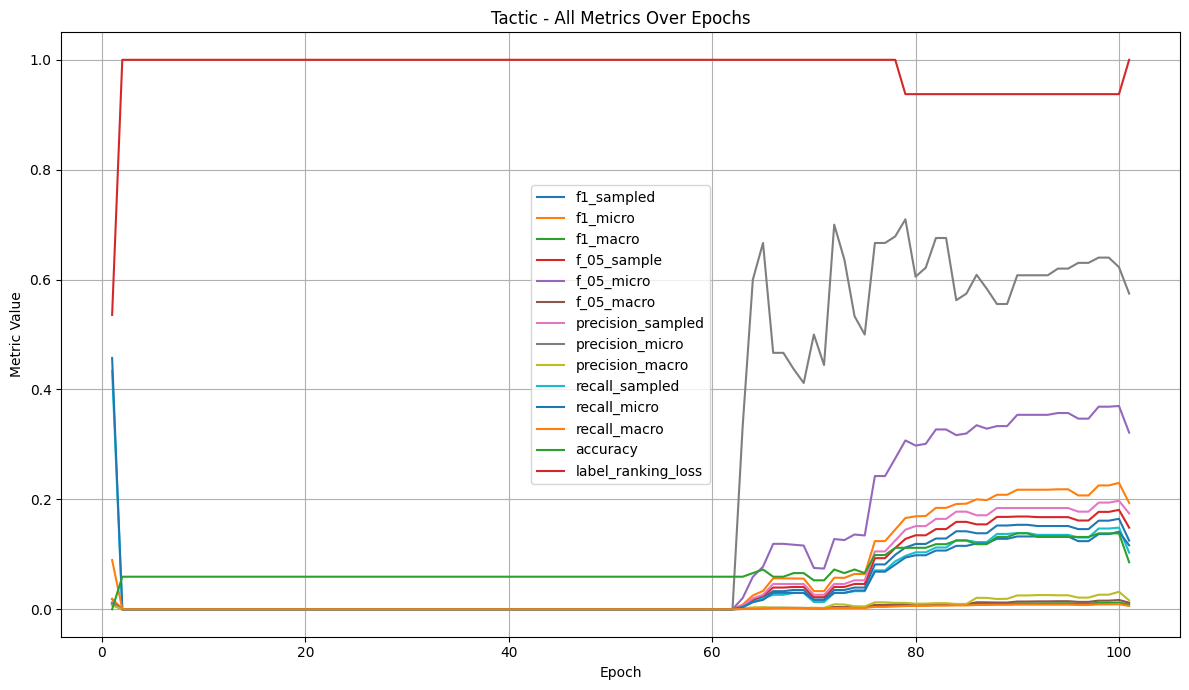

In [44]:
plt.figure(figsize=(12, 7))
epochs = range(1, len(metrics_log) + 1)
for metric_name, values in metrics_data.items():
    print(f"{metric_name}: {len(values)}")
    if metric_name != 'lrap' and metric_name != 'coverage_error':
        plt.plot(epochs, values, label=metric_name)

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Tactic - All Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

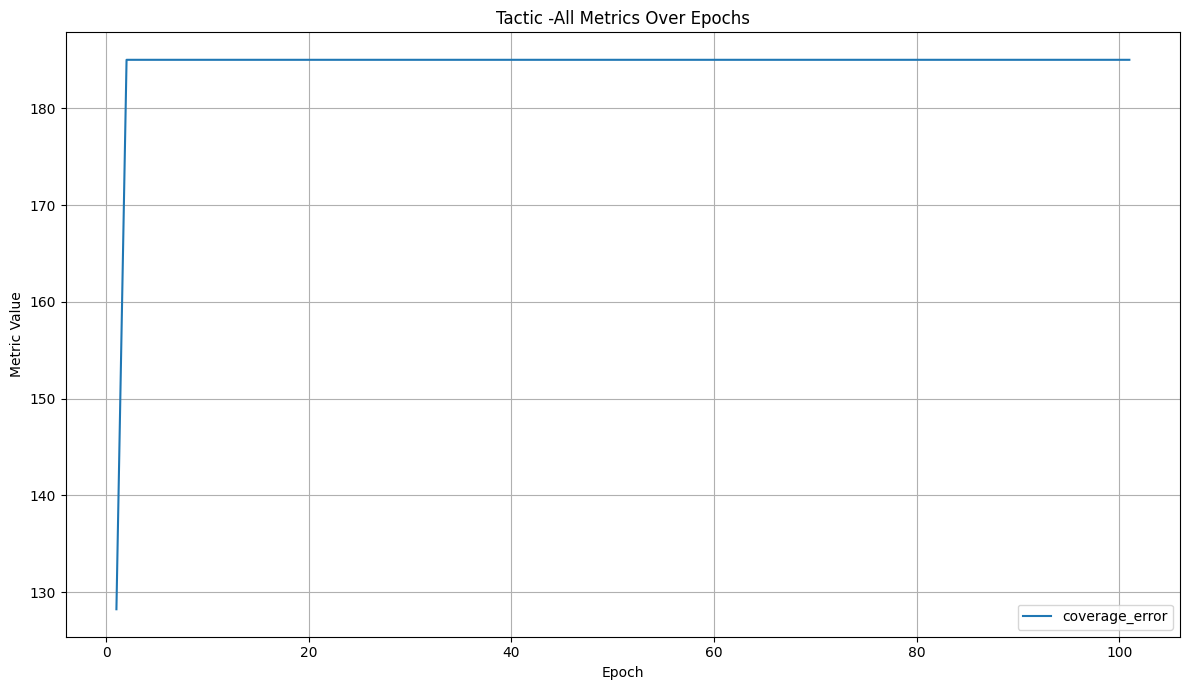

In [45]:
plt.figure(figsize=(12, 7))
epochs = range(1, len(metrics_log) + 1)
for metric_name, values in metrics_data.items():
    # print(f"{metric_name}: {len(values)}")
    if metric_name == 'coverage_error':
        plt.plot(epochs, values, label=metric_name)

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Tactic -All Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

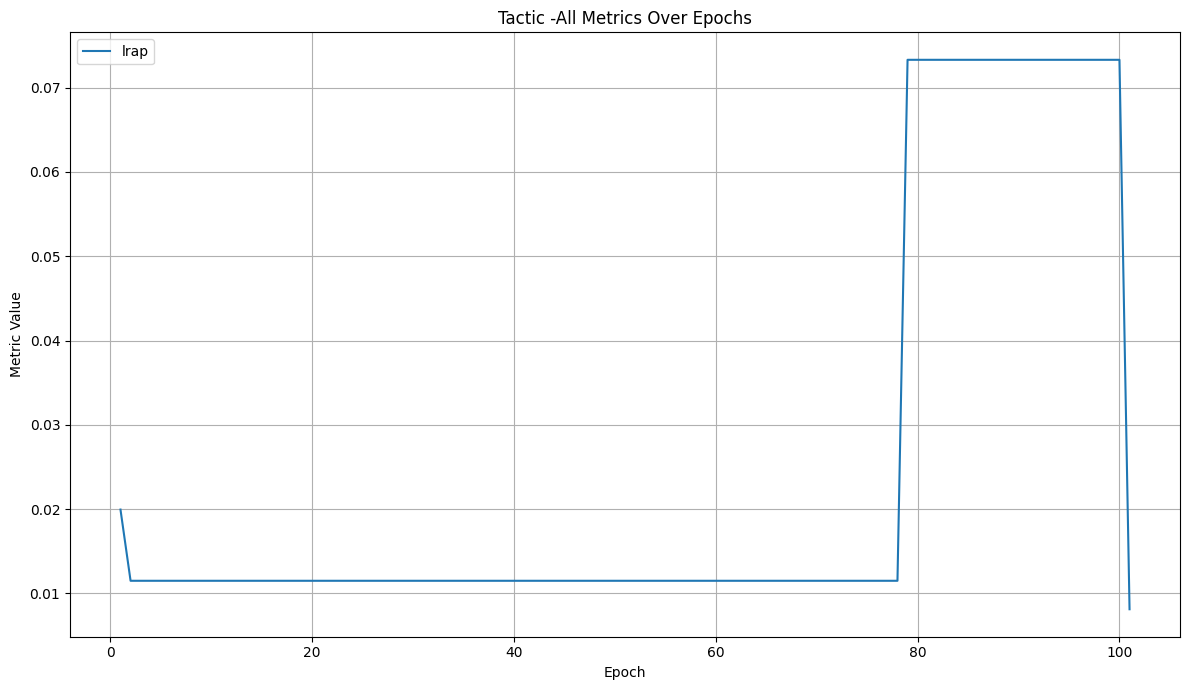

In [46]:
plt.figure(figsize=(12, 7))
epochs = range(1, len(metrics_log) + 1)
for metric_name, values in metrics_data.items():
    # print(f"{metric_name}: {len(values)}")
    if metric_name == 'lrap':
        plt.plot(epochs, values, label=metric_name)

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Tactic -All Metrics Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [88]:
def print_F1_based_on_distribution(y_true, y_pred, Y, columns):
  fig,ax = plt.subplots()

  results = pd.DataFrame(columns = columns)
  results.loc[len(results)] = f1_score(y_true, y_pred, average=None)


  Y_count = Y.apply(np.sum, axis=0)

  Y_count_sorted = Y_count[16:-3].sort_values(ascending=False)

  ax.bar(Y_count_sorted.index, Y_count_sorted.values)
  ax.set_xlabel("Techniques")
  ax.set_ylabel("Number of CVEs")
  plt.xticks(rotation=90)

  ax2=ax.twinx()
  ax2.plot(Y_count_sorted.index, results[Y_count_sorted.index].iloc[0], color='red')
  ax2.set_ylabel("F1 Score")

  ax = plt.gca()
  plt.show()

In [78]:
def print_precision_based_on_distribution(y_true, y_pred, Y, columns):
  fig,ax = plt.subplots()

  results = pd.DataFrame(columns = columns)
  results.loc[len(results)] = precision_score(y_true, y_pred, average=None)


  Y_count = Y.apply(np.sum, axis=0)

  # print(Y_count[0:14])

  Y_count_sorted = Y_count[16:-3].sort_values(ascending=False)


  ax.bar(Y_count_sorted.index, Y_count_sorted.values)
  ax.set_xlabel("Techniques")
  ax.set_ylabel("Number of CVEs")
  plt.xticks(rotation=90)

  ax2=ax.twinx()
  ax2.plot(Y_count_sorted.index, results[Y_count_sorted.index].iloc[0], color='red')
  ax2.set_ylabel("Precision Score")

  ax = plt.gca()
  plt.show()

In [79]:
def compute_metrics(predicted_y, true_y, metric_function, columns, limit):
  results = pd.DataFrame(columns = columns)
  if (metric_function == accuracy_score):
    results.loc[len(results)] = metric_function(true_y, predicted_y)
  else:
    results.loc[len(results)] = metric_function(true_y, predicted_y, average=None)

  sorted_results = results.sort_values(by=0, axis=1, ascending=False)

  for col in sorted_results.columns[:limit]:
        print(f"{col}: {sorted_results[col].values[0]}")

  return sorted_results.iloc[:, :limit]

In [80]:
df = pd.read_csv('merged_all_columns.csv', encoding='utf-8')
# df_attack['tactic_label'] = df_attack.apply(lambda x: list(x[TACTIC]), axis=1)
# df_attack['technique_label'] = df_attack.apply(lambda x: list(x[TECHNIQUE]), axis=1)

df_tactic_labels = df[TACTIC]
df_technique_labels = df[TECHNIQUE]

df['tactic_label'] = df.apply(lambda x: list(x[TACTIC]), axis=1)
df['technique_label'] = df.apply(lambda x: list(x[TECHNIQUE]), axis=1)

df['text_clean'] = df['Text'].map(lambda t: preprocess(t))


train, test = train_test_split(df, test_size=0.2, random_state=2222)
validation, test = train_test_split(test, test_size=0.5, random_state=2222)


In [81]:
print("------Validation results --------")
print(BEST_F1)

print("F1 scores per class")
y_train_df = train.drop(train.columns[0:2], axis=1)

f1_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, f1_score, test.columns[16:-3], 185)
print("----------------------------------")

print("Recall scores per class")
recall_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, recall_score, test.columns[16:-3], 185)
print("----------------------------------")

print("Precision scores per class")
precision_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, precision_score, test.columns[16:-3], 185)
print("----------------------------------")

print("Accuracy scores per class")
acc_best_metrics = compute_metrics(BEST_PREDICTED, BEST_TRUE, accuracy_score, test.columns[16:-3], 185)

------Validation results --------
0.182115305364104
F1 scores per class
T1499: 0.6486486486486487
T1059: 0.46153846153846156
T1203: 0.4186046511627907
T1204: 0.2222222222222222
T1189: 0.2
T1005: 0.11764705882352941
T1190: 0.10810810810810811
T1068: 0.07407407407407407
T1001: 0.0
T1014: 0.0
T1016: 0.0
T1018: 0.0
T1020: 0.0
T1021: 0.0
T1025: 0.0
T1027: 0.0
T1029: 0.0
T1030: 0.0
T1033: 0.0
T1036: 0.0
T1003: 0.0
T1008: 0.0
T1010: 0.0
T1006: 0.0
T1007: 0.0
T1046: 0.0
T1041: 0.0
T1047: 0.0
T1048: 0.0
T1053: 0.0
T1055: 0.0
T1049: 0.0
T1052: 0.0
T1057: 0.0
T1056: 0.0
T1069: 0.0
T1071: 0.0
T1072: 0.0
T1074: 0.0
T1078: 0.0
T1080: 0.0
T1082: 0.0
T1083: 0.0
T1087: 0.0
T1090: 0.0
T1091: 0.0
T1092: 0.0
T1095: 0.0
T1098: 0.0
T1102: 0.0
T1104: 0.0
T1105: 0.0
T1037: 0.0
T1039: 0.0
T1040: 0.0
T1011: 0.0
T1012: 0.0
T1113: 0.0
T1112: 0.0
T1111: 0.0
T1110: 0.0
T1106: 0.0
T1114: 0.0
T1119: 0.0
T1115: 0.0
T1129: 0.0
T1132: 0.0
T1133: 0.0
T1134: 0.0
T1123: 0.0
T1124: 0.0
T1125: 0.0
T1120: 0.0
T1140: 0.0
T1137

T1005    88
T1006     0
T1007     0
T1008     0
T1010     1
         ..
T1619     0
T1620     1
T1621     0
T1622     0
T1647     0
Length: 183, dtype: object


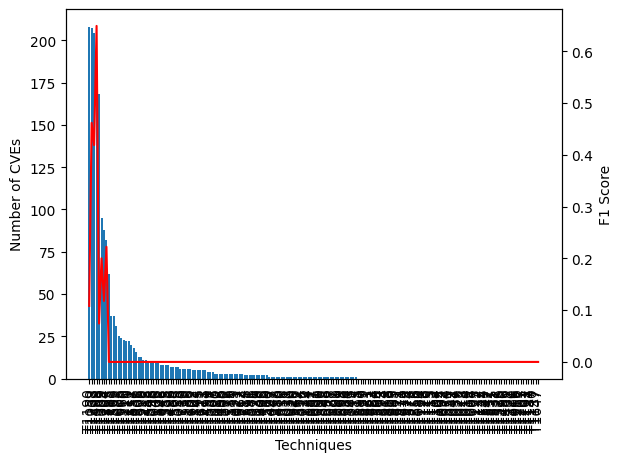

In [82]:
print_F1_based_on_distribution(BEST_PREDICTED, BEST_TRUE, y_train_df,  test.columns[16:-3])

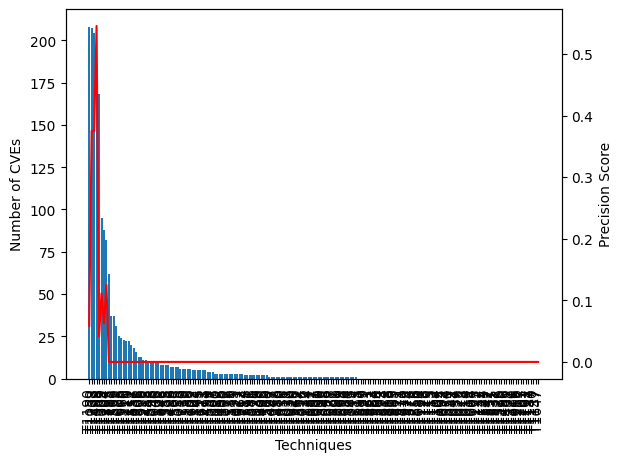

In [83]:
print_precision_based_on_distribution(BEST_PREDICTED, BEST_TRUE, y_train_df,  test.columns[16:-3])

In [84]:
def print_F1_based_on_distribution(y_true, y_pred, Y, columns):
  fig,ax = plt.subplots()

  results = pd.DataFrame(columns = columns)
  results.loc[len(results)] = f1_score(y_true, y_pred, average=None)


  Y_count = Y.apply(np.sum, axis=0)

  Y_count_sorted = Y_count[16:-3].sort_values(ascending=False)
  Y_count_sorted = Y_count_sorted[Y_count_sorted > 25]

  ax.bar(Y_count_sorted.index, Y_count_sorted.values)
  ax.set_xlabel("Techniques")
  ax.set_ylabel("Number of CVEs")
  plt.xticks(rotation=90)

  ax2=ax.twinx()
  ax2.plot(Y_count_sorted.index, results[Y_count_sorted.index].iloc[0], color='red')
  ax2.set_ylabel("F1 Score")

  ax = plt.gca()
  plt.show()

In [85]:
def print_precision_based_on_distribution(y_true, y_pred, Y, columns):
  fig,ax = plt.subplots()

  results = pd.DataFrame(columns = columns)
  results.loc[len(results)] = precision_score(y_true, y_pred, average=None)


  Y_count = Y.apply(np.sum, axis=0)

  # print(Y_count[0:14])

  Y_count_sorted = Y_count[16:-3].sort_values(ascending=False)
  Y_count_sorted = Y_count_sorted[Y_count_sorted > 25]


  ax.bar(Y_count_sorted.index, Y_count_sorted.values)
  ax.set_xlabel("Techniques")
  ax.set_ylabel("Number of CVEs")
  plt.xticks(rotation=90)

  ax2=ax.twinx()
  ax2.plot(Y_count_sorted.index, results[Y_count_sorted.index].iloc[0], color='red')
  ax2.set_ylabel("Precision Score")

  ax = plt.gca()
  plt.show()

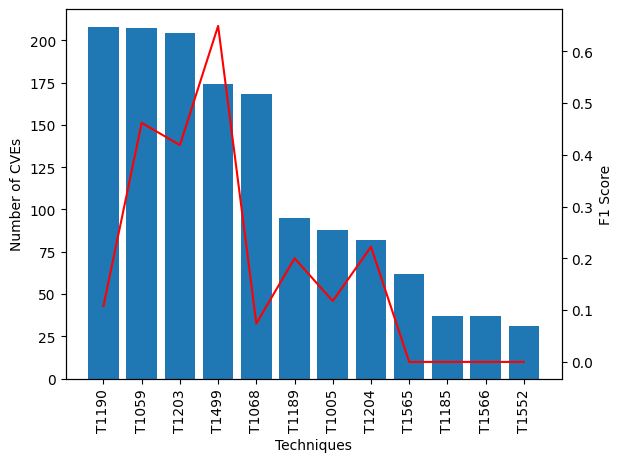

In [86]:
print_F1_based_on_distribution(BEST_PREDICTED, BEST_TRUE, y_train_df,  test.columns[16:-3])

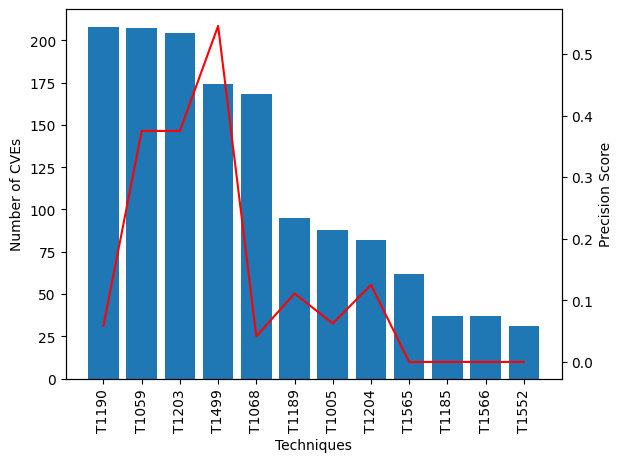

In [87]:
print_precision_based_on_distribution(BEST_PREDICTED, BEST_TRUE, y_train_df,  test.columns[16:-3])